In [19]:
%matplotlib inline

In [4]:
from linescanning import prf
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
from statsmodels.stats.weightstats import DescrStatsW
from prfpy import stimulus
import yaml
from scipy import io
from copy import deepcopy
import matplotlib.patches as mpatches 
from matplotlib import gridspec

opd = os.path.dirname
opj = os.path.join

## <h1> Analysis of the influence of pRF size on the effect of memantine on V1 suppression </h1>
This notebook is similar to the first part of the 'memantine_effects.ipynb' notebook, except it groups vertices based on pRF size rather than eccentricity.

In [5]:
with open('/data1/projects/Meman1/projects/pilot/code/floris/prf_analysis.yml') as f:
    analysis_info = yaml.safe_load(f)

dm = io.loadmat(opj('/data1/projects/Meman1/projects/pilot/code', 'design_task-2R.mat'))['stim']

# define the pRF stimulus
prf_stim = stimulus.PRFStimulus2D(
    screen_size_cm=analysis_info['screen_size_cm'],
    screen_distance_cm=analysis_info['screen_distance_cm'],
    design_matrix=dm[:,:,5:40],
    TR=analysis_info['TR'])

prf_stim2 = stimulus.PRFStimulus2D(
    screen_size_cm=analysis_info['screen_size_cm'],
    screen_distance_cm=analysis_info['screen_distance_cm'],
    design_matrix=dm[:,:,5:],
    TR=analysis_info['TR'])

ss = prf_stim.screen_size_degrees
max_ecc_size = ss/2.0

In [6]:
# define fitting boundaries
norm_bounds = {'x':(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x
               'y':(-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
               'prf_size': (0.2, 1.5*ss),  # prf size
               'A': (0,1000),  # prf amplitude
               'C': tuple(analysis_info['norm']['surround_amplitude_bound']),  # surround amplitude
               'surr_size': (0.1, 3*ss),  # surround size
               'B': tuple(analysis_info['norm']['neural_baseline_bound']),  # neural baseline
               'D': tuple([float(item) for item in analysis_info['norm']['surround_baseline_bound']])} # surround baseline

In [7]:
# Define randomization
conditions = {
    'sub-001': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-002': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-003': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-004': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-005': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-007': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-008': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-010': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-012': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-013': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-015': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-016': {'memantine': 'ses-2', 'placebo': 'ses-3'}
}

# All subs but with sub-015 excluded
newsubs = ['sub-001','sub-002','sub-003','sub-004','sub-005','sub-007','sub-008','sub-010','sub-012','sub-013','sub-016']

# Define basic settings
minr2=0.1
minecc=0.5 #The minimum
maxecc=4.5 #The maximum eccentricity you want to use

deriv='/data1/projects/Meman1/projects/pilot/derivatives'
model='norm'

placebo_patch = mpatches.Patch(color='royalblue', label='placebo')
memantine_patch = mpatches.Patch(color='firebrick', label='memantine')

In [10]:
class Add_pRF_profile:
    # Class to do some filtering on a pRFmodelFitting object on Gaussian model. You mainly specify the eccentricities that you want to look at, your minimum r2, and potentially a ROI
    # It returns an object with most of the characteristics of the pRFmodelFitting, but also adds FWHM and FWMIN
    
    def __init__(self,
                 pRFmodelFitting=None,
                 data=None,
                 design=None,
                 model=None,
                 stage=None,
                 params=None,
                 roi=None,
                 excludenegampl=False,
                 normalizeprofile=False,
                 eccmask=[minecc, maxecc],
                 r2mask=minr2):
        
        self.pRFmodelFitting=pRFmodelFitting
        if isinstance(self.pRFmodelFitting, prf.pRFmodelFitting):
            # if pRFmodelFitting object, get the necessary settings from here
            self.data=self.pRFmodelFitting.data
            self.model=self.pRFmodelFitting.model
            self.stage=self.pRFmodelFitting.stage
            self.params=prf.Parameters(params=getattr(self.pRFmodelFitting, f"{self.model}_{self.stage}"), model=self.model).to_df()
            self.design=self.pRFmodelFitting.design_matrix

        else:
            # else, take from manual input
            self.data=data
            self.model=model
            self.stage=stage
            self.params=params
            self.design=design
            
        # some additional settings
        self.excludenegampl=excludenegampl
        self.normalizeprofile=normalizeprofile
        self.eccmask=eccmask
        self.r2mask=r2mask
        self.roi=roi

        # select vertices based on roi...
        if self.roi is not None:
            try:
                self.params=self.params.loc[self.roi]
                print("ROI has", len(self.roi), "values")
            except:
                print("Not a valid ROI, give an array with vertex numbers for the ROI")
                print(len(self.roi))
                
        # drop vertices based on eccentricity and r2 boundaries
        self.params.loc[self.params['ecc'].values < self.eccmask[0]] = np.nan
        self.params.loc[self.params['ecc'].values > self.eccmask[1]] = np.nan
        self.params.loc[self.params['r2'].values < self.r2mask] = np.nan

        # drop vertices based on biological plausibility
        self.params.loc[self.params['surr_size'].values < self.params['prf_size'].values] = np.nan
        self.params.loc[self.params['prf_size'].values < 1.01*norm_bounds['prf_size'][0]] = np.nan

        print("Excluding", self.params.isna().any(axis=1).sum(), 'vertices based on mask...')
        self.params=self.params.dropna()

        # drop vertices if they have a negative pRF amplitude
        if self.excludenegampl:
            self.params.loc[self.params['prf_ampl'].values < 0] = np.nan
            print("Excluding", self.params.isna().any(axis=1).sum(), 'negative pRFs...')
            self.params=self.params.dropna()
        
        # initialize profile characteristics
        self.x = np.linspace(-10,10,2000).astype('float32')
        self.profile_df = pd.DataFrame(index=self.params.index, columns=self.x)

        # function to calculate profile, fwhm given an Add_pRF_profile object and a vertex index
        def profile_fwhm_fwmin(self, index):
            x = self.x
            params = self.params.loc[index]

            # calculate the activation pRF profile (and the volume underneath pRF)
            profile_act = params.prf_ampl * np.exp(-0.5*(x**2) / (params.prf_size**2))
            volume_act = np.sqrt(2*np.pi*(params.prf_size**2)) # NOT USED NOW, CAN BE USED LATER!!

            if self.model=='gauss':
                # calculate halfmax and fwhmax
                half_max = np.max(profile_act, axis=0)/2
                fwhmax = np.abs(2*x[np.argmin(np.abs(profile_act-half_max), axis=0)])

                return fwhmax, half_max
            
            elif self.model=='norm':
                # calculate the normalization pRF profule (and the volume underneath pRF)
                profile_norm = params.surr_ampl * np.exp(-0.5*(x**2) / (params.surr_size**2))
                volume_norm = np.sqrt(2*np.pi*(params.surr_size**2)) # NOT USED NOW, CAN BE USED LATER!!

                # calculate full profile based on constants, profile act, and profile norm
                profile = (profile_act + params.B)/(profile_norm + params.D) - (params.B/params.D)
                
                # normalize RFs if necessary
                if self.normalizeprofile:
                    profile /= np.max(profile)

                # calculate halfmax and fwhmax
                half_max = np.max(profile, axis=0)/2
                fwhmax = np.abs(2*x[np.argmin(np.abs(profile-half_max), axis=0)])

                minim = np.min(profile, axis=0)
                maxim = np.max(profile, axis=0)

                fwmin= np.abs(2*x[np.argmin(profile, axis=0)])                

                # if fwmin is this large, it does not make any sense really as there is no visible surround. leaving it in would create an outlier    
                if fwmin==float(20.0):
                    fwmin=np.nan
                
                if minim>0 or maxim<0.01 or profile[999]<maxim:
                    fwhmax=np.nan
                    half_max=np.nan
                    minim=np.nan
                    maxim=np.nan
                    fwmin=np.nan
                    
                return fwhmax, half_max, minim, maxim, fwmin

        # now, add the profile measures to the dataframe
        if self.model=='gauss':
            for vert in self.params.index:
                fwhmaxx, half_maxx = profile_fwhm_fwmin(self, vert)
                self.params.loc[vert, 'fwhm'] = fwhmaxx
                self.params.loc[vert, 'half_max'] = half_maxx

        elif self.model=='norm':
            for vert in self.params.index:
                fwhmaxx, half_maxx, minimm, maximm, fwminn = profile_fwhm_fwmin(self, vert)
                if abs(minimm)/maximm == np.inf:
                    print(vert)
                self.params.loc[vert, 'fwhm'] = fwhmaxx
                self.params.loc[vert, 'half_max'] = half_maxx
                self.params.loc[vert, 'minimum'] = minimm
                self.params.loc[vert, 'maximum'] = maximm
                self.params.loc[vert, 'min/max'] = minimm/maximm
                self.params.loc[vert, 'fwmin'] = fwminn
                self.params.loc[vert, 'basetopeak']= np.abs(maximm-minimm)

<h2>0. Extracting DN model parameters for all subjects in both conditions </h2>

In [9]:
# Here, I will store all output after looping over the subjects
prffits = {
    sub: {
        'fits': {'placebo': None, 'memantine': None},
        'roi_vertices': {'V1_vertices': None, 'V2_vertices': None, 'V3_vertices': None}
    } for sub in conditions.keys()}

In [11]:
for sub in conditions.keys():
    print(f"Working on subject {sub}...")
    print("")

    #######################################################
    ###### LOADING IN ROIs ################
    #######################################################

    print("Getting ROI vertices...")
    print("")

    finalrois= opj(deriv, 'freesurfer',sub, 'customlabel', 'roidrawing', 'final')
    
    #Load V1 vertices from left hemisphere, together with the number of vertices in the left hemisphere so indexing for right hemisphere works appropriately; the .label files start from 0 and work per hemisphere, whereas Inkscape merges the two hemispheres together.
    V1_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V1.label'))
    V2_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V2.label'))
    V3_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V3.label'))

    all_lh = nib.freesurfer.read_geometry(opj(deriv, 'freesurfer', sub, 'surf', 'lh.inflated'))

    #Load V1 vertices from right hemisphere. 
    V1_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V1.label'))
    V2_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V2.label'))
    V3_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V3.label'))

    all_rh = nib.freesurfer.read_geometry(opj(deriv, 'freesurfer', sub, 'surf', 'rh.inflated'))

    # Get the right indices for the right hemisphere by adding the number of vertices in left hemisphere to the ROI indices for the right hemisphere.
    V1_rh = V1_rh + len(all_lh[0])
    V2_rh = V2_rh + len(all_lh[0])
    V3_rh = V3_rh + len(all_lh[0])

    # Concatenate the 2 and sort them such that they are in the right order
    V1_vertices = np.sort(np.concatenate([V1_lh, V1_rh]))
    V2_vertices = np.sort(np.concatenate([V2_lh, V2_rh]))
    V3_vertices = np.sort(np.concatenate([V3_lh, V3_rh]))

    roi_vertices = np.sort(np.concatenate([V1_vertices, V2_vertices, V3_vertices]))

    prffits[sub]['roi_vertices']['V1_vertices'] = V1_vertices
    prffits[sub]['roi_vertices']['V2_vertices'] = V2_vertices
    prffits[sub]['roi_vertices']['V3_vertices'] = V3_vertices

    for condition in ['placebo', 'memantine']:
        print(f"Working on {condition}...")
        print("")

        # First, get path to the appropriate files
        design = prf.read_par_file(opj(deriv, 'prf', sub, 'design_task-2R.mat'))
        outputdata = opj('/data1/projects/Meman1/projects/pilot/code/floris/output', sub)

        # Load data
        data = np.load(opj(deriv, 'prf', sub, conditions[sub][condition], f'{sub}_{conditions[sub][condition]}_task-2R_hemi-LR_desc-avg_bold.npy'))

        # Initialize empty array of parameters with the appropriate shape
        params_norm = np.zeros(shape=(data.shape[1], 12))

        #######################################################
        ###### GETTING ALL PARAMETERS IN RIGHT SPOT ###########
        #######################################################

        print("Putting parameters in right place...")
        print("")

        for i in range(20):
            roivertices = np.load(opj(outputdata, 'roivertices', f'roivertices_{sub}_slice-{i}.npy'))
            paramss= np.load(opj(outputdata, 'fits', f'{sub}_{conditions[sub][condition]}_task-2R_model-norm_stage-iter_desc-prfparams_slice-{i}.npy'))

            for index, roivertex in enumerate(roivertices):
                params_norm[roivertex] = paramss[index]

        #######################################################
        ###### LOADING IN PARAMETERS IN OBJECT ################
        #######################################################
        print("Creating pRFmodelFitting object...")
        print("")
        
        # initialize empty model
        norm_obj= prf.pRFmodelFitting(
            data.T,
            design_matrix=design,
            TR=1.5,                     # default
            model=model,                # default, can be 'gauss', 'css', 'dog', 'norm'
            stage="iter",               # default
            verbose=True,               # keep track of what we're doing,
            fix_bold_baseline=True      # fix the BOLD baseline at 0
        )

        # load params
        norm_obj.load_params(params_norm, model=model, stage="iter")

        #######################################################
        ###### CREATING AN ADD_PRF_PROFILE OBJ ################
        #######################################################
        print("Creating an Add_pRF_profile...")
        print("")

        norm_filtered = Add_pRF_profile(norm_obj, r2mask=0.1, eccmask=[0.5, 4.5], roi=roi_vertices) # You can change things here in the settings if you want

        #######################################################
        ###### ADDING TO DICTIONARY NOW     ###################
        #######################################################

        prffits[sub]['fits'][condition] = norm_filtered

Working on subject sub-001...

Getting ROI vertices...

Working on placebo...

Putting parameters in right place...

Creating pRFmodelFitting object...

Design has 5 more volumes than timecourses, trimming from beginning of design to (100, 100, 220)
Reading settings from '/data1/projects/Meman1/projects/pilot/code/prf_analysis.yml'

---------------------------------------------------------------------------------------------------
Check these important settings!
 Screen distance: 196cm
 Screen size: 39.3cm
 TR: 1.5s
---------------------------------------------------------------------------------------------------

Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0] (fit=True)
Using constraint(s): ['tc', 'tc']
Inserting parameters from <class 'numpy.ndarray'> as 'norm_iter' in <linescanning.prf.pRFmodelFitting object at 0x7fe10bc58ca0>
Creating an Add_pRF_profile...

ROI has 4374 values
Excluding 554 vertices based on mask...
Working on memantine...

Putting parameters in right p

In [13]:
def get_descriptives(row, param, weighted=False):
    ## This is a function to quickly get descriptive metric for individual pRF parameters, weighted by the R2 of individual vertices
    
    totest = row.dropna(subset=param)

    if weighted:
        descriptives = DescrStatsW(totest[param], weights=totest['r2'])
        mean = descriptives.mean
        std = descriptives.std
        n = len(totest)
        sem = std/np.sqrt(n)
    else:
        mean = totest[param].mean()
        std = totest[param].std()
        n = len(totest)
        sem = std/np.sqrt(n)
    
    return mean, std, sem

In [14]:
def profile_fwhm_fwmin(params, normalizeprofile=False, model='norm'):
    ## This is a function to calculate the linearized pRF profile of individual vertices based on model parameters

    x = np.linspace(-10,10,2000)

    # calculate the activation pRF profile (and the volume underneath pRF)
    profile_act = params['A'] * np.exp(-0.5*(x**2) / (params['prf_size']**2))
    volume_act = np.sqrt(2*np.pi*(params['prf_size']**2)) # NOT USED NOW, CAN BE USED LATER!!

    if model=='gauss':
        return profile_act
            
    elif model=='norm':
        # calculate the normalization pRF profule (and the volume underneath pRF)
        profile_norm = params['C'] * np.exp(-0.5*(x**2) / (params['surr_size']**2))
        volume_norm = np.sqrt(2*np.pi*(params['surr_size']**2)) # NOT USED NOW, CAN BE USED LATER!!

        # calculate full profile based on constants, profile act, and profile norm
        profile = (profile_act + params['B'])/(profile_norm + params['D']) - (params['B']/params['D'])
                
        # normalize RFs if necessary
        if normalizeprofile:
            profile /= np.max(profile)

        # calculate halfmax and fwhmax
        half_max = np.max(profile, axis=0)/2
        fwhmax = np.abs(2*x[np.argmin(np.abs(profile-half_max), axis=0)])

        minim = np.min(profile, axis=0)
        maxim = np.max(profile, axis=0)

        fwmin= np.abs(2*x[np.argmin(profile, axis=0)])                

        # if the profile has these weird characteristics    
        if fwmin==float(20.0) or minim>0 or maxim<0.01 or profile[999]<maxim:
            profile = np.empty((0,2000))
        
        return profile

In [15]:
def get_mean_profile(profilearray, weighted=False, weights=None):
    ## This is a function to calculate descriptive metrics of an array of pRF responses for different vertices, potentially weighted by R2 
    
    if weighted:
        mean_profile = DescrStatsW(profilearray, weights=weights)
        mean = mean_profile.mean
        std = mean_profile.std
        n = profilearray.shape[0]
        sem = std/np.sqrt(n)
        ci = 1.96*sem

    else:
        mean = profilearray.mean(axis=0)
        std = profilearray.std(axis=0)
        n = profilearray.shape[0]
        sem = std/np.sqrt(n)
        ci = 1.96*sem
    
    return mean, std, sem, ci

<h2> 1. Calculate effect of pRF size on relative minimum of pRF profile </h2>

In [24]:
# Characteristics of eccentricity bins
num_bins=20
bin_edges = np.linspace(0.5,4.5, num_bins+1)
metric = 'min/max'

# Calculate the necessary metrics for all the subjects and saving them
meandict = {
    sub: {
        condition: {
            'scatter': {},
            'profile': {'mean': {}, 'ci': {}},
            'bar': {}
        } for condition in ['placebo', 'memantine']
    } | {'difference': {}}
    for sub in conditions.keys()}

# Plot 1: Metric versus Eccentricity in both conditions
for index, sub in enumerate(conditions.keys()):

    valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>0.3 or 
                                prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>0.3)]
    
    ############## 1. CALCULATE DIFFERENCES #####################
    filtered_params_plac = prffits[sub]['fits']['placebo'].params.loc[valid_vertices_V1_shared]
    filtered_params_mem = prffits[sub]['fits']['memantine'].params.loc[valid_vertices_V1_shared]
    
    # Create new dataframe with differences
    diff_df = pd.DataFrame(columns=['vertex_nr', f'{metric} diff', 'mean_prf_size','mean_r2'])

    diff_df['vertex_nr'] = valid_vertices_V1_shared

    diff_df[f'{metric} diff'] = filtered_params_plac[metric].values-filtered_params_mem[metric].values

    for param in ['prf_size','r2']:
        diff_df[f'mean_{param}'] = np.mean([filtered_params_plac[param], filtered_params_mem[param]], axis=0)

    # Now, calculate the difference while grouped in eccentricity bins
    shapemetrics_V1 = diff_df.dropna(subset=f'{metric} diff')

    # Calculate eccentricity bins for each ROI
    shapemetrics_V1['prf_size_bin'] = pd.qcut(shapemetrics_V1['mean_prf_size'], q=num_bins, labels=range(20))

    # Calculate mean for each group
    df_mean_ecc_v1 = shapemetrics_V1.groupby('prf_size_bin').apply(lambda x: np.average(x['mean_prf_size'], weights=x['mean_r2']))
    df_mean_metric_v1 = shapemetrics_V1.groupby('prf_size_bin').apply(lambda x: np.average(x[f'{metric} diff'], weights=x['mean_r2']))
    
    # Put in the dictionary
    meandict[sub]['difference']['mean_prf_size'] = df_mean_ecc_v1
    meandict[sub]['difference']['mean_metric'] = df_mean_metric_v1

    for index, condition in enumerate(['placebo', 'memantine']):
        
        ############## 2. CALCULATE ECCENTRICITY VS METRIC PER CONDITION  ###################
        shapemetrics_V1 = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared].dropna(subset=metric)

        # Calculate eccentricity bins for each ROI
        shapemetrics_V1['prf_size_bin'] = pd.qcut(shapemetrics_V1['prf_size'], q=num_bins, labels=range(20))
        
        # Calculate mean for each group
        df_mean_ecc_v1 = shapemetrics_V1.groupby('prf_size_bin').apply(lambda x: np.average(x['prf_size'], weights=x['r2']))
        df_mean_metric_v1 = shapemetrics_V1.groupby('prf_size_bin').apply(lambda x: np.average(x[metric], weights=x['r2']))

        df_sem_metric_v1 = shapemetrics_V1.groupby('prf_size_bin').apply(lambda x: np.std(x[metric]) / np.sqrt(len(x[metric])))


        meandict[sub][condition]['scatter']['mean_prf_size'] = df_mean_ecc_v1
        meandict[sub][condition]['scatter']['mean_metric'] = df_mean_metric_v1
        meandict[sub][condition]['scatter']['sem_metric'] = df_sem_metric_v1

        ############## 3. CALCULATE MEAN OF GROUP IN LOW VERSUS HIGH ECCENTRICITIES  ###################
        for ecc_range in [(0,0.9),(0.9,4.5)]:
                                
            filtered_params_ecc = shapemetrics_V1.loc[(shapemetrics_V1['prf_size']>ecc_range[0]) & (shapemetrics_V1['prf_size']<ecc_range[1])]

            mean_metric,_,_ = get_descriptives(filtered_params_ecc, 'min/max',weighted=True)

            meandict[sub][condition]['bar'][f'{ecc_range[0]}-{ecc_range[1]}'] = mean_metric     

        ############## 4. CALCULATE PROFILE PER CONDITION  ################### --> THIS CAN BE PUT IN THE OTHER LOOP
        shapemetrics_low = shapemetrics_V1[shapemetrics_V1['prf_size']<0.9]
        shapemetrics_high = shapemetrics_V1[shapemetrics_V1['prf_size']>0.9]

        allprofiles_low = {'vertex': [],'r2': [],'profile': []}
        allprofiles_high = {'vertex': [],'r2': [],'profile': []}
        
        for row in shapemetrics_low.iterrows():
            profile = profile_fwhm_fwmin(row[1],normalizeprofile=True)
            
            if profile.size != 0:
                allprofiles_low['vertex'].append(row[0])
                allprofiles_low['r2'].append(shapemetrics_low.loc[row[0]]['r2'])
                allprofiles_low['profile'].append(profile)

        for row in shapemetrics_high.iterrows():
            profile = profile_fwhm_fwmin(row[1],normalizeprofile=True)

            if profile.size != 0:
                allprofiles_high['vertex'].append(row[0])
                allprofiles_high['r2'].append(shapemetrics_high.loc[row[0]]['r2'])
                allprofiles_high['profile'].append(profile)
        

        # Calculate mean
        mean_low,_,_,ci_low = get_mean_profile(np.vstack(allprofiles_low['profile']), weighted=True, weights=allprofiles_low['r2'])
        mean_high,_,_,ci_high = get_mean_profile(np.vstack(allprofiles_high['profile']), weighted=True, weights=allprofiles_high['r2'])

        meandict[sub][condition]['profile']['mean']['0-0.9'] = mean_low
        meandict[sub][condition]['profile']['ci']['0-0.9'] = ci_low

        meandict[sub][condition]['profile']['mean']['0.9-4.5'] = mean_high
        meandict[sub][condition]['profile']['ci']['0.9-4.5'] = ci_high

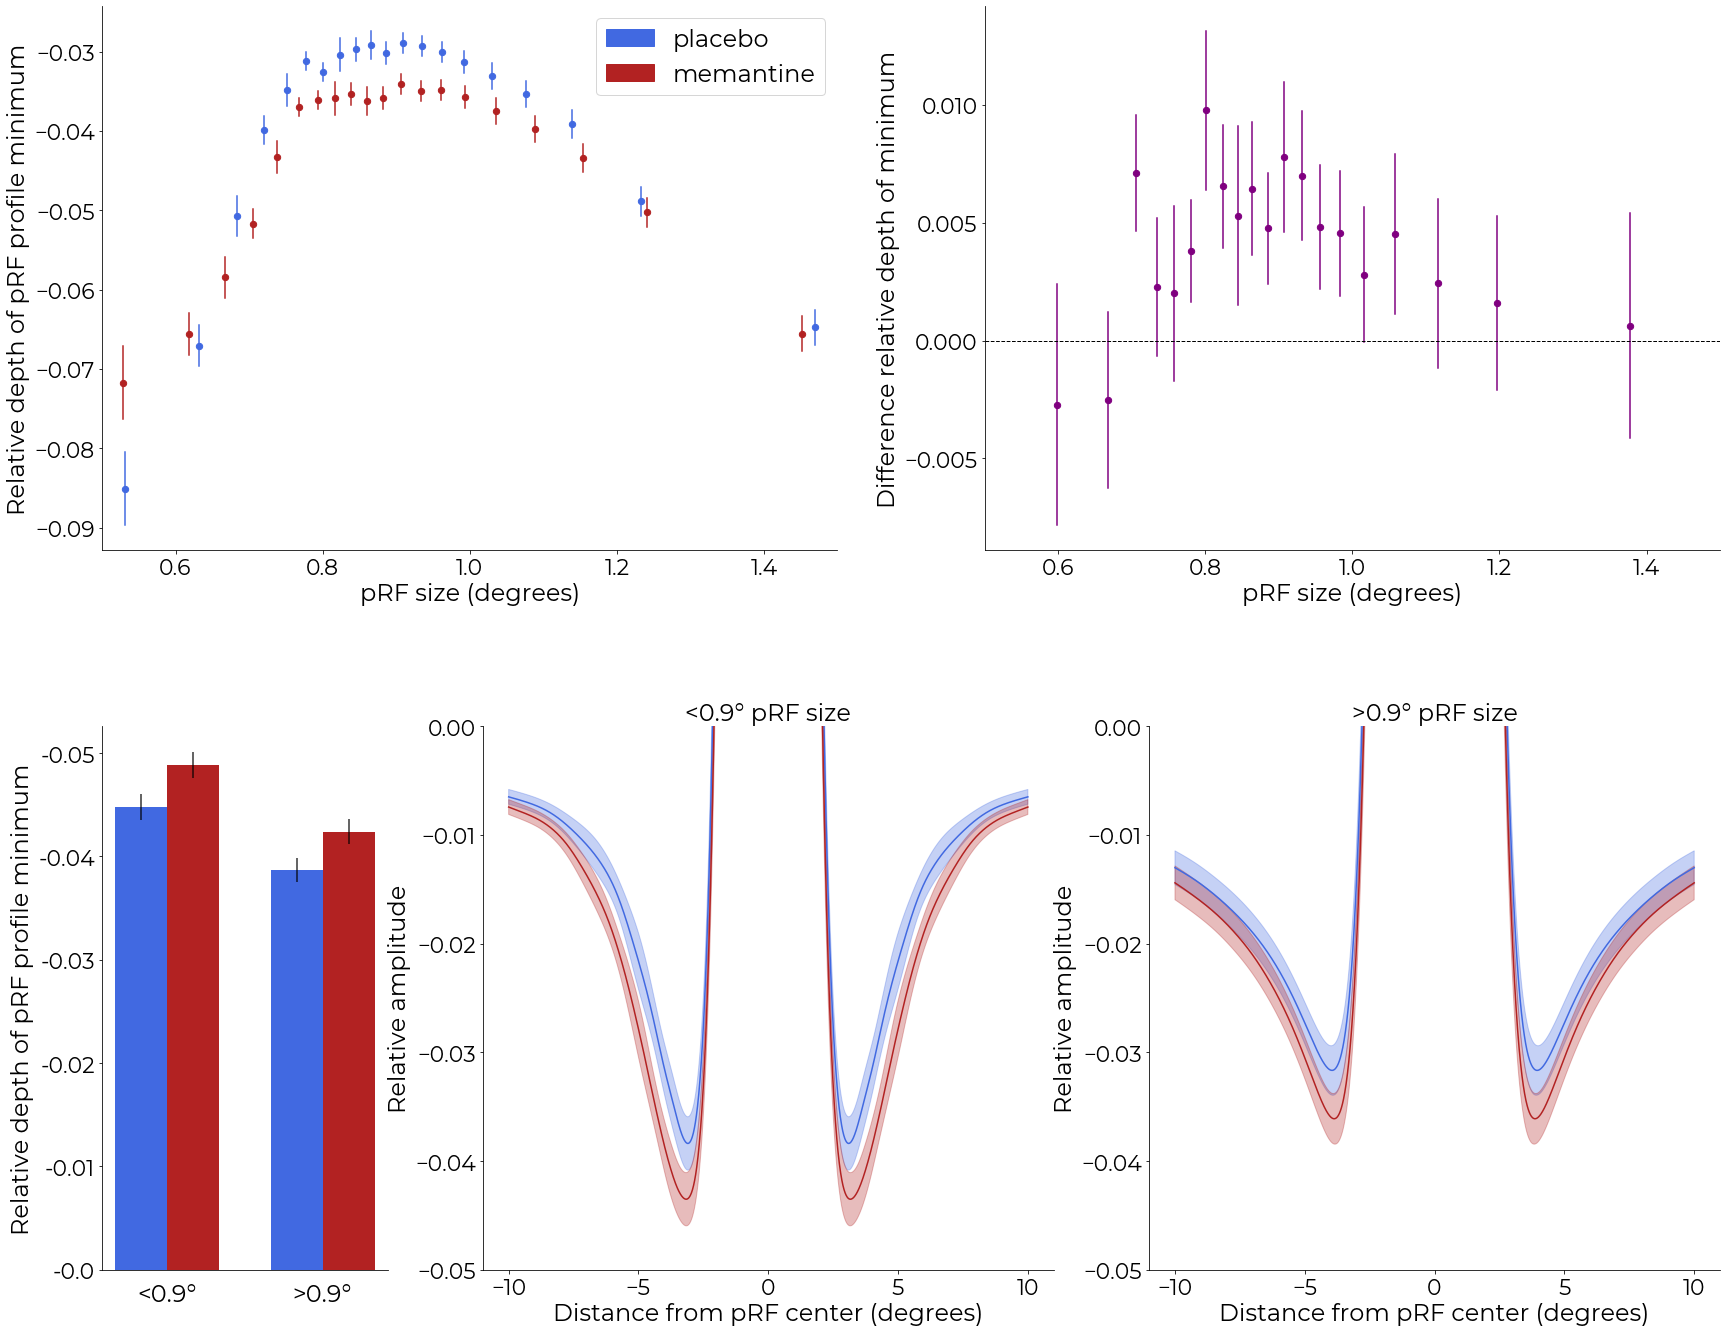

In [25]:
colorlist = {'placebo':'royalblue','memantine':'firebrick'}
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 22})

# Create the figure
fig = plt.figure(figsize=(29, 20))

subfigures = fig.subfigures(nrows=2, ncols=1)

axtop=subfigures[0].subplots(nrows=1, ncols=2)

axbottom=subfigures[1].subplots(nrows=1, ncols=3, gridspec_kw={'width_ratios': [1,2,2]})


######## PANEL A ##########

# Clean SEM calculations for all subjects:
subavgs_scatter = {sub: np.mean(np.vstack([meandict[sub][condition]['scatter']['mean_metric'].values for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
grandavg_scatter = np.mean(np.vstack([meandict[sub][condition]['scatter']['mean_metric'].values for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

meandict_scatter_corrected = {sub: {condition: meandict[sub][condition]['scatter']['mean_metric']-subavgs_scatter[sub]+grandavg_scatter for condition in ['placebo','memantine']} for sub in newsubs}

for index, condition in enumerate(['placebo', 'memantine']):
    mean_ecc_allsubs = np.mean(pd.concat([meandict[sub][condition]['scatter']['mean_prf_size'] for sub in newsubs], axis=1), axis=1) # you don't need to know this SEM anyway
    mean_metric_allsubs = np.mean(pd.concat([meandict_scatter_corrected[sub][condition] for sub in newsubs], axis=1), axis=1)

    sem_metric_allsubs = np.std(pd.concat([meandict_scatter_corrected[sub][condition] for sub in newsubs], axis=1), axis=1)/np.sqrt(11)

    axtop[0].scatter(mean_ecc_allsubs, mean_metric_allsubs, color=colorlist[condition], label=condition, s=40)

    for x, y, sem in zip(mean_ecc_allsubs.values, mean_metric_allsubs.values, sem_metric_allsubs.values):
        axtop[0].plot([x, x], [y - sem, y + sem], color=colorlist[condition])
        
axtop[0].set_xlim([0.5,1.5])
axtop[0].set_ylabel('Relative depth of pRF profile minimum', fontsize=24)
axtop[0].set_xlabel('pRF size (degrees)', fontsize=24)
axtop[0].legend(handles=[placebo_patch, memantine_patch],fontsize=24)

######## PANEL B ##########
mean_ecc_allsubs = np.mean(pd.concat([meandict[sub]['difference']['mean_prf_size'] for sub in newsubs], axis=1), axis=1) # you don't need to know this SEM anyway
mean_metric_allsubs = np.mean(pd.concat([meandict[sub]['difference']['mean_metric'] for sub in newsubs], axis=1), axis=1)

sem_metric_allsubs = np.std(pd.concat([meandict[sub]['difference']['mean_metric'] for sub in newsubs], axis=1), axis=1)/np.sqrt(11)

axtop[1].scatter(mean_ecc_allsubs, mean_metric_allsubs, color='purple', s=40)

for x, y, sem in zip(mean_ecc_allsubs.values, mean_metric_allsubs.values, sem_metric_allsubs.values):
    axtop[1].plot([x, x], [y - sem, y + sem], color='purple')

axtop[1].hlines(0, 0.5,1.5, linestyle='--', color='black',linewidth=1)
axtop[1].set_xlim([0.5,1.5])
axtop[1].set_ylabel('Difference relative depth of minimum', fontsize=24)
axtop[1].set_xlabel('pRF size (degrees)', fontsize=24)

######## PANEL C ##########
counter=0

for ecc in ['0-0.9', '0.9-4.5']:

    # Clean SEM calculations for all subjects:
    subavgs_bar = {sub: np.mean(np.vstack([meandict[sub][condition]['bar'][ecc] for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
    grandavg_bar = np.mean(np.vstack([meandict[sub][condition]['bar'][ecc] for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

    meandict_bar_corrected = {sub: {condition: meandict[sub][condition]['bar'][ecc]-subavgs_bar[sub]+grandavg_bar for condition in ['placebo','memantine']} for sub in newsubs}
 
    for condition in ['placebo', 'memantine']:

        mean = np.mean(np.vstack([meandict[sub][condition]['bar'][ecc] for sub in newsubs]))
        sem = np.std(np.vstack([meandict_bar_corrected[sub][condition]for sub in newsubs]))/np.sqrt(11)
        
        axbottom[0].bar(0.20*counter + 0.1, -1*mean, width=0.20, color=colorlist[condition])
        axbottom[0].vlines(0.20*counter+0.1, ymin=-mean-sem, ymax=-mean+sem, color='black', alpha=0.8)

        counter += 1
    counter += 1

axbottom[0].text(0.20, -0.003, '<0.9°', horizontalalignment='center', fontsize=24)
axbottom[0].text(0.80, -0.003, '>0.9°', horizontalalignment='center', fontsize=24)

axbottom[0].set_yticklabels(['-' + str(tick) for tick in axbottom[0].get_yticks()])
axbottom[0].set_xticks([])
axbottom[0].set_ylabel('Relative depth of pRF profile minimum', fontsize=24)

######### PANEL D AND E #########
for jndex, ecc in enumerate(['0-0.9', '0.9-4.5']):
    subavgs = {sub: np.mean(np.vstack([meandict[sub][condition]['profile']['mean'][ecc] for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
    grandavg = np.mean(np.vstack([meandict[sub][condition]['profile']['mean'][ecc] for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

    meandict_corrected = {sub: {condition: meandict[sub][condition]['profile']['mean'][ecc]-subavgs[sub]+grandavg for condition in ['placebo','memantine']} for sub in newsubs}

    for index, condition in enumerate(['placebo', 'memantine']):
        mean_allsubs = np.mean(np.vstack([meandict[sub][condition]['profile']['mean'][ecc] for sub in newsubs]), axis=0)

        sem_allsubs = np.std(np.vstack([meandict_corrected[sub][condition] for sub in newsubs]), axis=0)/np.sqrt(11)

        ci_allsubs = 1.96*sem_allsubs

        axbottom[1+jndex].plot(np.linspace(-10,10, 2000), mean_allsubs, color = colorlist[condition])
        axbottom[1+jndex].fill_between(np.linspace(-10,10, 2000), mean_allsubs-ci_allsubs, mean_allsubs+ci_allsubs, color = colorlist[condition], alpha=0.3)

        axbottom[1+jndex].set_ylim(-0.05,0)
        axbottom[1+jndex].set_xlabel('Distance from pRF center (degrees)', fontsize=24)
        axbottom[1+jndex].set_ylabel('Relative amplitude', fontsize=24)

axbottom[1].set_title(f'<0.9° pRF size', fontsize=24)
axbottom[2].set_title(f'>0.9° pRF size', fontsize=24)

sns.despine()
# Adjust the layout
plt.tight_layout()

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/V1_relativeminimum_effect_pRF_size.png"
# Display the plot

plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

Now, test statistically:

In [22]:
dfs = []

for sub in newsubs:
    print("Working on", sub)
    
    valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>0.3 or 
                                prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>0.3)]
    
    for condition in ['placebo','memantine']:
        filtered_params = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared]
        
        for ecc_range in [(0,0.9),(0.9,4.5)]:
                                
            filtered_params_ecc = filtered_params.loc[(filtered_params['prf_size']>ecc_range[0]) & (filtered_params['prf_size']<ecc_range[1])]
            
            mean_metric,_,_ = get_descriptives(filtered_params_ecc, 'min/max',weighted=True)

            data = {'sub':sub,
                    'condition':condition,
                    'prf_size':f'{str(ecc_range[0])}-{str(ecc_range[1])}', 
                    'minmax': mean_metric}
            
            dfs.append(data)
            
mean_metric_df = pd.DataFrame(dfs)

Working on sub-001
Working on sub-002
Working on sub-003
Working on sub-004
Working on sub-005
Working on sub-007
Working on sub-008
Working on sub-010
Working on sub-012
Working on sub-013
Working on sub-016


In [23]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('minmax ~ prf_size * condition + C(sub)', data=mean_metric_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                          sum_sq    df         F    PR(>F)
prf_size            4.335821e-04   1.0  2.208421  0.147694
condition           1.675046e-04   1.0  0.853173  0.363026
C(sub)              1.539820e-02  10.0  7.842969  0.000005
prf_size:condition  4.196808e-07   1.0  0.002138  0.963430
Residual            5.889939e-03  30.0       NaN       NaN
